In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm

data = pd.read_csv("./data/test_data.csv")

# Preprocessing macro data and calculating Z-scores

## Cleaning up 'Year' in macro_data

In [2]:
macro_data = pd.read_csv("./data/macro_data.csv", header = None)
macro_data = macro_data.T
new_header = macro_data.iloc[0] # Columns names
macro_data = macro_data[1:]
macro_data.columns = new_header
tmp = map(lambda x:int(x), macro_data['Year']) # Converting Year to int
macro_data['Year'] = list(tmp)

## Other Preprocessing

In [3]:
tmp = macro_data.drop(columns = 'Year')
cond = tmp != 'no data'
tmp = tmp.replace(to_replace = 'no data', value = np.nan) # Replaacing missing data with Nan

## Transforming GDP data to z-scores. 

In [4]:
tmp_1 = tmp.to_numpy(dtype = float)

z_score_mean = np.nanmean(tmp_1, axis = 0)
z_score_std = np.nanstd(tmp_1, axis = 0)

# Calculating Avg and Std of macro data accoring to each
# country for the entire time period
df_stat = pd.DataFrame([z_score_mean, z_score_std], columns = new_header[1:])
df_stat.index = ['Average', 'Std Dev']

country_wise_Z_scores = pd.DataFrame()
i = 0

while i < (tmp.shape[0]):
    country_wise_Z_scores[i] = (pd.array(tmp.iloc[i], float) - df_stat.iloc[0]) / df_stat.iloc[1]
    i = i + 1

country_wise_Z_scores = country_wise_Z_scores.T
Z_scores = country_wise_Z_scores.copy()
Z_scores.insert(0, "Year", np.array(macro_data["Year"]))
Z_scores = Z_scores.set_index('Year')

# Evaluating TTC PD, PiT PD and Asset Correlation

## Calculating Flow Rates

In [5]:
label_tmp = data.columns[0] # Extracting first labeel ('Period) of Exposuree Data
exp_df = (data.copy()).drop(labels = label_tmp, axis = 1).to_numpy()
nrow = exp_df.shape[0]
ncol = exp_df.shape[1]

i = 0
flow_rate_tmp = np.empty([(nrow - 1), (ncol - 1)])

while i < nrow - 2: 
    flow_rate_tmp[i][0:] = exp_df[i+1][1:(ncol)] / exp_df[i][0:(ncol - 1)]
    i = i + 1

flow_rate = pd.DataFrame(flow_rate_tmp, columns = data.columns[1:ncol])

flow_rate = flow_rate.where(cond = flow_rate < 1, other = 1)
flow_rate = flow_rate.where(cond = flow_rate > 0, other = np.nan)

## TTC PD & PiT PD

In [6]:
TTC_PD = np.nanmean(flow_rate, axis = 0)
TTC_PD = np.append(TTC_PD, 1)
i = 0
while i < len(TTC_PD):
    TTC_PD[i] = np.product(TTC_PD[i:])
    i = i + 1

# Function to calcualte the PiT PD for 3 scenarios: Base, Upturn and Downturn
# using Vasicek model.
    
def PiT_PD(ttc_pd, z_scores, country, yr):
    rho = 0.24 - (0.12 * ((1-np.exp(-50 * ttc_pd)) / (1 - np.exp(-50)))) # Asset Correlation
    m_base = pd.array(z_scores.filter(like = country, axis = 1).loc[yr]) # macro variable
    m_up = pd.array(z_scores.filter(like = country, axis = 1).loc[yr]) + df_stat[country][1]
    m_down = pd.array(z_scores.filter(like = country, axis = 1).loc[yr]) - df_stat[country][1] 
    p = norm.ppf(ttc_pd, loc = 0, scale = 1) # quantile of TTC PD
    base_pit = norm.cdf((p - np.multiply(np.sqrt(rho), m_base) / np.sqrt( 1 - rho)), loc = 0, scale = 1)
    up_pit = norm.cdf((p - np.multiply(np.sqrt(rho), m_up) / np.sqrt( 1 - rho)), loc = 0, scale = 1)
    down_pit = norm.cdf((p - np.multiply(np.sqrt(rho), m_down) / np.sqrt( 1 - rho)), loc = 0, scale = 1)
    pit_pd = pd.DataFrame([base_pit, up_pit, down_pit], index = ["Base", "Upturn", "Downturn"])
    return(pit_pd.T, rho)   

# LGD Calculation

In [7]:
a = exp_df[0:-1, -1]
b = exp_df[0:-1, -2]
c = exp_df[1:, -1]

LGD = pd.DataFrame((a + b - c)/(a + b))
LGD = LGD.where(cond = LGD < 1, other = 1)
LGD = LGD.where(cond = LGD > 0, other = np.nan)
LGD = np.nanmean(LGD)

# ECL Calculation

In [8]:
def ECL(exp, LGD, w1, w2, w3, ttc_pd, z_scores, country, yr):
    PD = PiT_PD(ttc_pd, z_scores, country, yr)
    final_exp = exp[-1]
    tmp_1 = (PD[0].to_numpy() * LGD) # PD * LGD
    ECL_scenarios = np.round(np.einsum("ij, i -> ij", tmp_1, final_exp), 2)
    ECL_final = np.average(ECL_scenarios, weights = [w1, w2, w3], axis = 1)
    return(ECL_final, PD[0], PD[1])

In [38]:
# Requiredd arguments are
# exp, LGD, w1, w2, w3, ttc_pd, z_scores, country, yr
# 'Afghanistan', 'Bahrain', 'Canada', 'Egypt', 'India', 'Oman',
#       'Qatar', 'Saudi Arabia', 'United Arab Emirates', 'United Kingdom',
#       'United States'

ECL_tmp = ECL(exp_df, LGD, 0.5, 0.3, 0.2, TTC_PD, Z_scores, 'Bahrain', 2021)
ECL_final = round(pd.DataFrame(ECL_tmp[0], columns = ['Final ECL']), 2)
ECL_PD = ECL_tmp[1] 

ECL_per = round(np.nansum(ECL_tmp[0]) / np.nansum(exp_df[-1]), 2)

final_df = pd.DataFrame([exp_df[-1],TTC_PD, ECL_tmp[2]], index = ['Final Exposure', 'TTC PD', 'Asset Correlation']).T
final_df = pd.concat([final_df, ECL_PD, ECL_final], axis = 1)
final_df = final_df.set_index(data.columns[1:])
final_df

,Final Exposure,TTC PD,Asset Correlation,Base,Upturn,Downturn,Final ECL
Current,2859897.0,0.058396,0.126473,0.067538,0.006475,0.307263,141002.74
30 days,9576457.0,0.071980,0.123282,0.082526,0.009023,0.340214,544307.68
60 days,8771159.0,0.093198,0.121136,0.105812,0.013353,0.388806,599388.59
90 days,4822030.0,0.112692,0.120429,0.127065,0.017696,0.429791,378766.47
120 days,6775778.0,0.138593,0.120117,0.155099,0.024029,0.478962,620767.28
150 days,4892465.0,0.160733,0.120039,0.178885,0.029965,0.516778,500948.93
180 days,6596443.0,0.208504,0.120004,0.229709,0.044440,0.587737,822520.39
210 days,7833525.0,0.265512,0.120000,0.289574,0.064741,0.657955,1175784.21
240 days,7834415.0,0.331369,0.120000,0.357809,0.092447,0.724811,1397745.00
270 days,7284386.0,0.406859,0.120000,0.434938,0.130224,0.787477,1530374.63


In [39]:
ECL_per

0.19

# Plotting

In [11]:
import matplotlib.pyplot as plt

<AxesSubplot:>

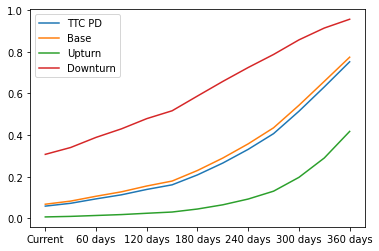

In [40]:
final_df_PD = final_df.drop(['Final Exposure', 'Asset Correlation', 'Final ECL'], axis = 1)
final_df_PD = final_df_PD.drop(index = ['> 360 days']) 
final_df_PD.plot()